# Explaining the TEDA Algorithm: Outlier Detection

- #### Algorithm developed in:

Angelov, Plamen. (2014). ***Anomaly detection based on eccentricity analysis***. 1-8. 10.1109/EALS.2014.7009497. 

- #### Code by:

Pedro Henrique Meira de Andrade (Git: pedrohmeiraa) - 14/jul/2022

- #### Text adapted from:

**Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Cassiano, J.; Costa, D.G. ***A TinyML Soft-Sensor Approach for Low-Cost Detection and Monitoring of Vehicular Emissions***. Sensors 2022, 22, 3838. https://doi.org/10.3390/s22103838

## 1. Definition

**TEDA** (*Typicality and Eccentricity Data Analytics*) algorithm was proposed by Angelov in 2014 to detect anomalies in data streams. This paper can be accessed at [Plamen Paper](https://www.researchgate.net/publication/301411485_Anomaly_detection_based_on_eccentricity_analysis).

Typicality is the similarity of a sample to the rest of the set (based on distances between samples), while eccentricity is its opposite when indicating how different a sample is from the rest of the collected data.
Datastreams.

TEDA uses the sum of the geometric distances between the analyzed sample and the other samples in the set. The higher this value, the greater the eccentricity of the sample in relation to the others and, consequently, the lower the value of typicality.

### For more information, please refer to the [TEDA repository](https://github.com/pedrohmeiraa/TEDA).

# 2. Hands on!

The following code snippets utilize the methods of the TEDA class developed in Python. The methods include the constructor that takes the *threshold* value, the *offline* method for pre-existing datasets, and the *online* method for data streams.

### 2.1 Importing modules and libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import seaborn as sns
from sklearn import preprocessing
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from random import randint, sample
import time

In [2]:
from teda import TEDA

### 2.2 Importing data:

We are going to use a modified dataset, as it was taken from a simulated distribution substation. The simulated data is based on SCADA supervisory system that acquired the value of the active power of the feeder (MW) every 15 minutes, totaling 96 measurements in one day.
In the following dataset, we will have 10 consecutive days.

In [3]:
data=pd.read_excel('Power.xlsx')

Passing the unit power to kW:

In [4]:
data['P'] = 1000*data['P']

In [5]:
data.head()

,Date,Hour,P
0,2010-01-01,00:00:00,770.0
1,2010-01-01,00:15:00,754.0
2,2010-01-01,00:30:00,754.0
3,2010-01-01,00:45:00,724.0
4,2010-01-01,01:00:00,724.0


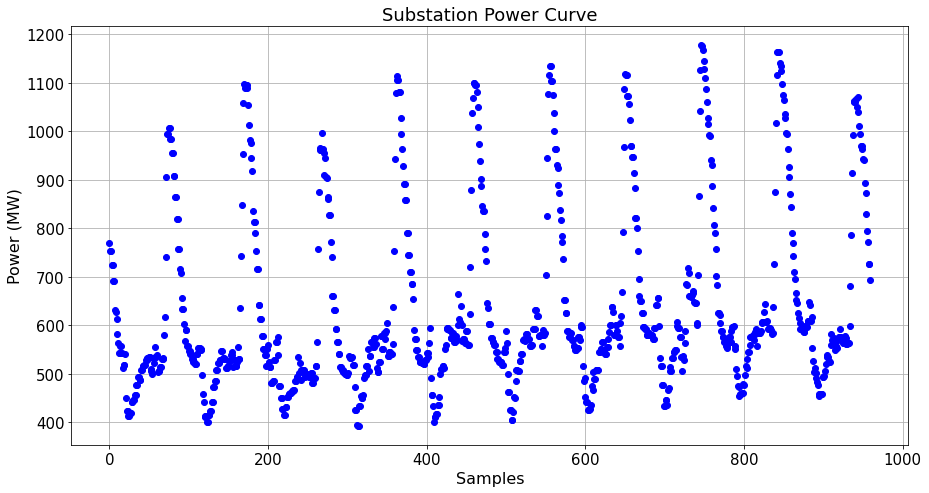

In [6]:
plt.figure(figsize=(15,7.7))
plt.grid()
plt.title("Substation Power Curve", fontsize=18)
plt.plot(data['P'], 'ob', linewidth=3.5)
plt.ylabel("Power (kW)", fontsize=16)
plt.xlabel("Samples", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 2.3 Inserting outliers

In [7]:
data['label'] = 0

In [8]:
t_in_samples = np.linspace(0, len(data['P']), len(data['P']))

In [9]:
outliers_percentage = 4/100
o = sample(range(10, len(data['P'])), k=np.round(outliers_percentage*len(data['P'])).astype(int))

#Outliers do tipo zero
z = o[0:np.round(len(o)/2).astype(int)]

#Outliers do tipo pico
p = o[np.round(len(o)/2).astype(int): -1]

len(o)

38

#### Peak-type outliers will have **twice** the magnitude. Therefore:

In [10]:
data['P with outliers'] = data['P']

In [11]:
data['P with outliers'].iloc[p] = 2*data['P'].iloc[p]
data['label'].iloc[p] = 1

c:\Users\Samsung\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Zero-type outliers has value equals **zero**:

In [12]:
data['P with outliers'].iloc[z] = 0
data['label'].iloc[z] = 1

### Let's see the new curve:

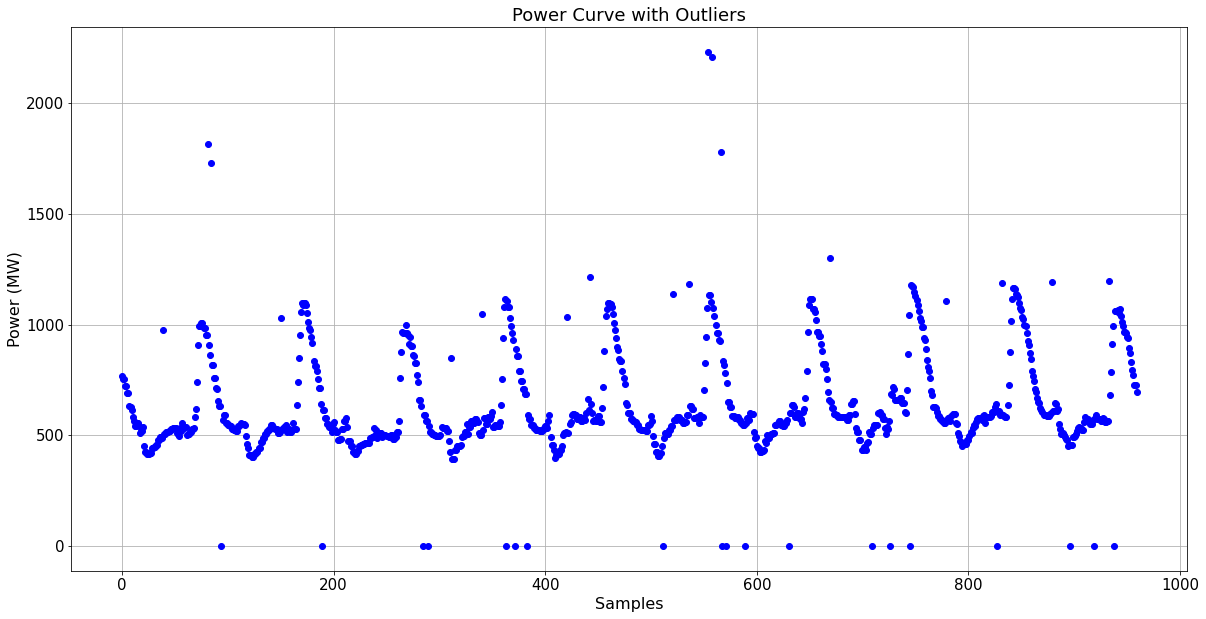

In [16]:
plt.figure(figsize=(20,10))
plt.grid()
plt.title("Power Curve with Outliers", fontsize=18)
plt.plot(data['P with outliers'], 'ob', linewidth=3.5)
plt.ylabel("Power (MW)", fontsize=16)
plt.xlabel("Samples", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Here, we can save this new dataframe considering the outliers:

In [14]:
data.to_excel("PowerWithOutliers.xlsx", sheet_name="Power", index=False)

In [15]:
data.head()

,Date,Hour,P,label,P with outliers
0,2010-01-01,00:00:00,770.0,0,770.0
1,2010-01-01,00:15:00,754.0,0,754.0
2,2010-01-01,00:30:00,754.0,0,754.0
3,2010-01-01,00:45:00,724.0,0,724.0
4,2010-01-01,01:00:00,724.0,0,724.0


# 3. Outlier Detection

## 3.1 TEDA Offline

In [12]:
teda = TEDA(threshold=2.35)
teda.run_offline(data, ['P'])

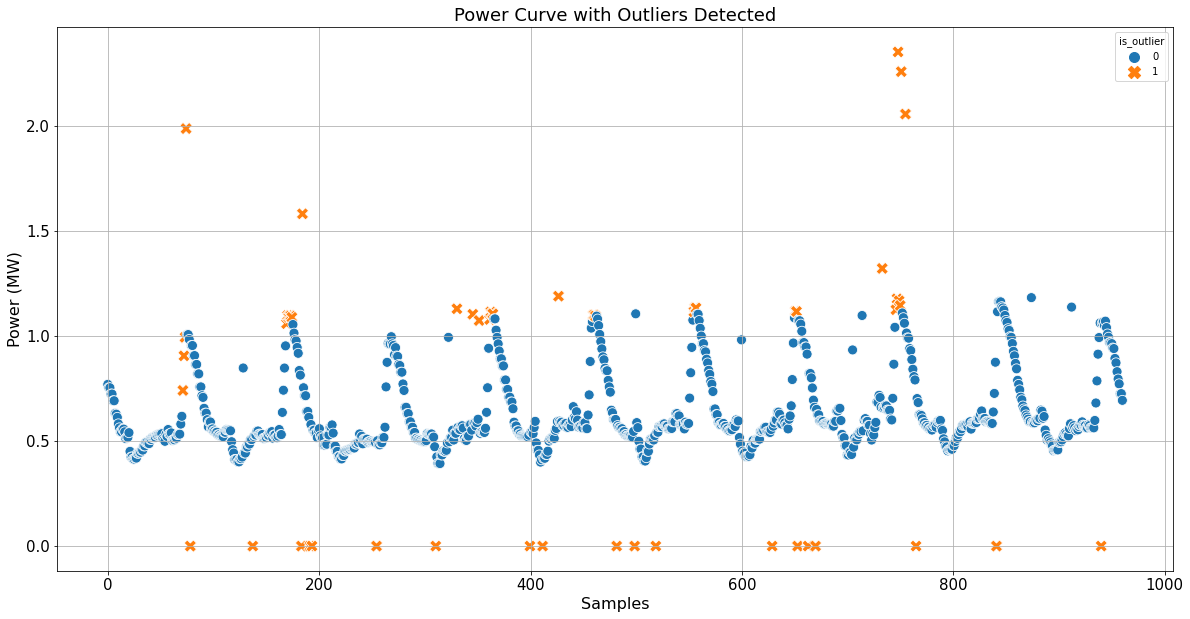

In [13]:

plt.figure(figsize=(20,10))
plt.grid()
plt.title("Power Curve with Outliers Detected", fontsize=18)
sns.scatterplot(x=t_in_samples, y=data['P'], hue=data['is_outlier'], style=data['is_outlier'], size=data['is_outlier'], sizes=(150, 100))
plt.ylabel("Power (MW)", fontsize=16)
plt.xlabel("Samples", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## 3.2 TEDA Online

In [14]:
teda_on = TEDA(threshold=2.35)
OUT = []
for t in data['P']:
    OUT.append(teda_on.run(t))

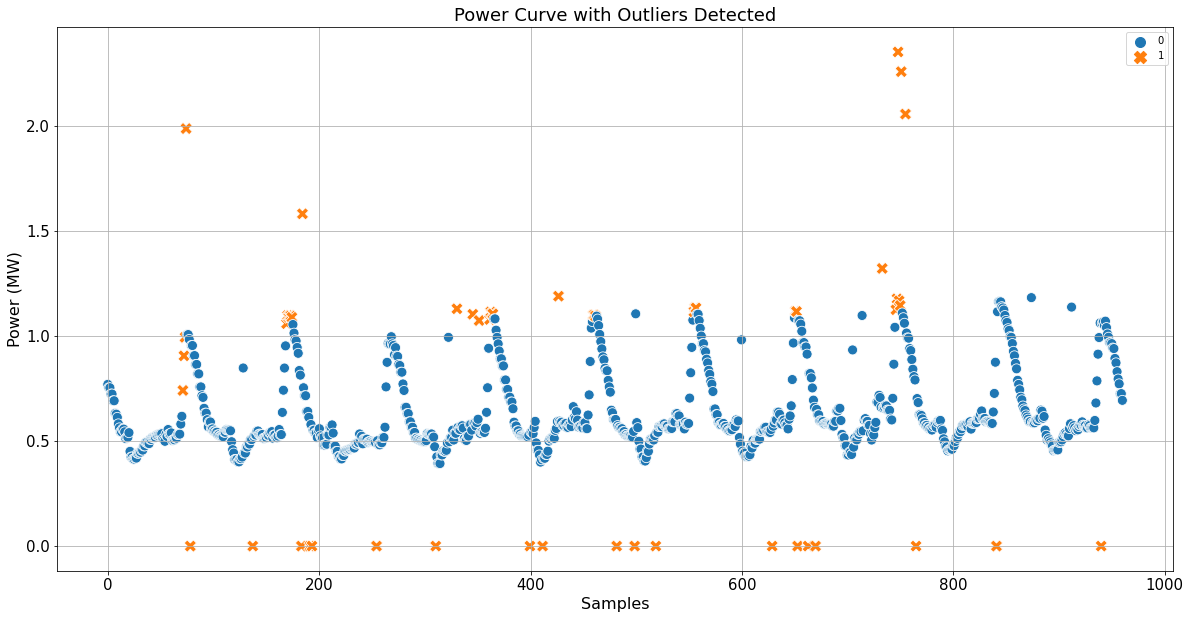

In [15]:
plt.figure(figsize=(20,10))
plt.grid()
plt.title("Power Curve with Outliers Detected", fontsize=18)
sns.scatterplot(x=t_in_samples, y=data['P'], hue=OUT, style=OUT, size=OUT, sizes=(150, 100))
plt.ylabel("Power (MW)", fontsize=16)
plt.xlabel("Samples", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# 4. Metrics evaluation:

## 4.1 Metrics

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score

#### Confusion matrix:

$$
CM = \begin{bmatrix}
TN & FP\\ 
FN & TP
\end{bmatrix}
$$

In [17]:
print(confusion_matrix(data['label'], data['is_outlier']))

[[898  25]
 [  8  29]]


#### Accuracy:

In [18]:
print(accuracy_score(data['label'], data['is_outlier']))

0.965625


#### Recall:

In [19]:
print(recall_score(data['label'], data['is_outlier']))

0.7837837837837838


#### Precision

In [20]:
print(precision_score(data['label'], data['is_outlier']))

0.5370370370370371


#### *f1* score:

In [21]:
print(f1_score(data['label'], data['is_outlier']))

0.6373626373626374


### To summarize: Classification report

#### Offline

In [22]:
print(classification_report(data['label'], data['is_outlier']))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       923
           1       0.54      0.78      0.64        37

    accuracy                           0.97       960
   macro avg       0.76      0.88      0.81       960
weighted avg       0.97      0.97      0.97       960



#### Online

In [23]:
print(classification_report(data['label'], OUT))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       923
           1       0.54      0.78      0.64        37

    accuracy                           0.97       960
   macro avg       0.76      0.88      0.81       960
weighted avg       0.97      0.97      0.97       960



## 4.2 "Grid Search":

#### Now, we are going to use several threshold values to see the TEDA behavior. In this Section, the metric used will be the f1 score:

In [27]:
# Threshold values
THR = [1.1, 1.25, 1.5, 1.75, 2, 2.25, 2.35, 2.45, 2.5, 3, 5, 7]

In [28]:
F1 = []
ACC = []
REC = []
PREC = []

for threshold in THR:
    teda = TEDA(threshold)
    teda.run_offline(data, ['P'])
    #TEDA Metrics
    f1 = f1_score(data['label'], data['is_outlier'])
    accuracy = accuracy_score(data['label'], data['is_outlier'])
    recall = recall_score(data['label'], data['is_outlier'])
    precision = precision_score(data['label'], data['is_outlier'])

    F1.append(f1)
    ACC.append(accuracy)
    REC.append(recall)
    PREC.append(precision)

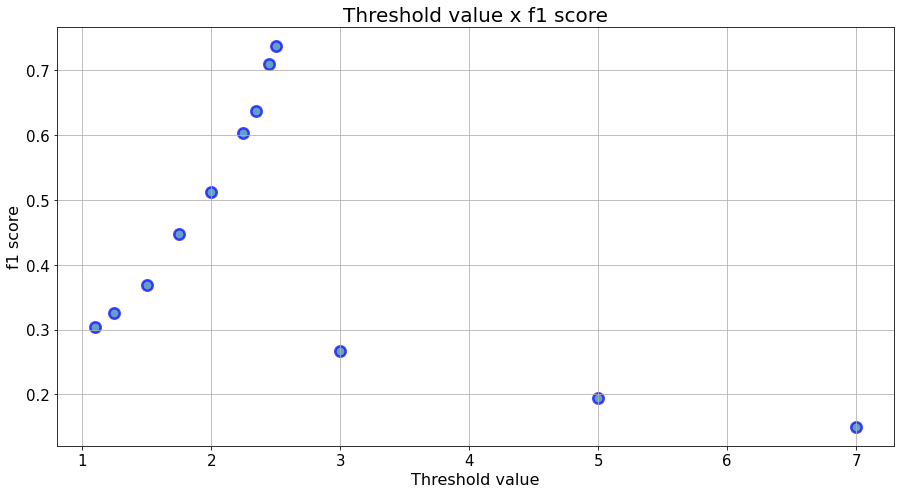

In [30]:
fig, ax = plt.subplots(figsize = (15,7.7))
ax.scatter(x=THR, y=F1, linewidth=2.5, s=110, alpha=0.7, edgecolors="b")
plt.title("Threshold value x f1 score", fontsize=20)
plt.xlabel("Threshold value", fontsize=16)
plt.ylabel("f1 score", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.show()

# 5. WandB

## WandB importing:

In [31]:
#!pip install wandb

In [32]:
import wandb
import logging

In [33]:
!wandb login 40f0acf51f839c9bfbed5c1f24e945ed8245e110

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Samsung/.netrc


#### Initialize a new W&B run to track this job

In [34]:
run = wandb.init(project="TEDARegressor", job_type="dataset-creation")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pedrohmeira (embarca-ai). Use `wandb login --relogin` to force relogin


In [35]:
# Create a new artifact, which is a sample dataset
dataset = wandb.Artifact('Power.xlsx', type='dataset')
# Add files to the artifact, in this case a simple text file
dataset.add_file('Power.xlsx')
# Log the artifact to save it as an output of this run
run.log_artifact(dataset)

### Configure logging

In [36]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

### Defining dictionaries:

In [37]:
metric_dict = {
    'name': 'accuracy',
    'goal': 'maximize'   
    }

In [38]:
parameters_dict = {
    #TEDA
    'Threshold': {
          'values': [1.1, 1.25, 1.5, 1.75, 2, 2.25, 2.35, 2.45, 2.5, 3, 5, 7]
        },

}

### Defining Sweep

In [39]:
seed = 41
sweep_config = {
    "method": "grid",
    "metric": metric_dict,
    "parameters": parameters_dict,

}
sweep_id = wandb.sweep(sweep_config, project="TEDARegressor")

Create sweep with ID: t2h8zqqd
Sweep URL: https://wandb.ai/embarca-ai/TEDARegressor/sweeps/t2h8zqqd


In [40]:
def train():
    with wandb.init() as run:
        OUT = []
        teda_sweep = TEDA(threshold=wandb.config.Threshold)
        for t in data['P']:
            #teda_sweep.run(t)
            OUT.append(teda_sweep.run(t))
            
        #TEDA Metrics
        f1 = f1_score(data['label'], OUT)
        accuracy = accuracy_score(data['label'], OUT)
        recall = recall_score(data['label'], OUT)
        precision = precision_score(data['label'], OUT)

        # Logging
        run.summary['f1_score'] = f1
        wandb.log({"f1_score": f1})
        run.summary['accuracy'] = accuracy
        wandb.log({"accuracy": accuracy})
        run.summary['recall'] = recall
        wandb.log({"recall": recall})
        run.summary['precision'] = precision
        wandb.log({"precision": precision})        

In [ ]:
wandb.agent(sweep_id, train)

# 6. Sweep Analysis

## 6.1 Visualization

Here, we can visualize the Sweep Results 👀. We have use the **Parallel Coordinates Plot 🔀** to map hyperparameter values to model metrics.
We've used to see the combinations of hyperparameters that led to the **best TEDA performance 📊**:


#### Sweep Power Data

![Sweep Power Data](figures/Power/Power_sweep_TEDA.png)

## Considering accuracy as the metric, the best performance of the TEDA algorithm occurs at a threshold of 2.5.

# 7. Homework 📝:
### Modify the distance type (*Euclidean* or *cosine* or *Mahalonobis*) in the algorithm.

# 8. References

[[1]](https://www.researchgate.net/publication/301411485_Anomaly_detection_based_on_eccentricity_analysis) Angelov, Plamen. (2014). *Anomaly detection based on eccentricity analysis*. 1-8. 10.1109/EALS.2014.7009497. 



[[2]](https://www.mdpi.com/1424-8220/22/10/3838) Andrade, P.; Silva, I.; Silva, M.; Flores, T.; Cassiano, J.; Costa, D.G. *A TinyML Soft-Sensor Approach for Low-Cost Detection and Monitoring of Vehicular Emissions*. Sensors 2022, 22, 3838. doi: 10.3390/s22103838

[[3]](https://ieeexplore.ieee.org/document/536707) A. Bernieri, G. Betta and C. Liguori, *"On-line fault detection and diagnosis obtained by implementing neural algorithms on a digital signal processor"* in IEEE Transactions on Instrumentation and Measurement, vol. 45, no. 5, pp. 894-899, Oct. 1996, doi: 10.1109/19.536707.
